# Learning Rate Schedules

Setting the learning rate for stochastic gradient descent (SGD) is crucially important when training neural networks because it controls both the speed of convergence and the ultimate performance of the network. One of the simplest learning rate strategies is to have a fixed learning rate throughout the training process. Choosing a small learning rate allows the optimizer find good solutions, but this comes at the expense of limiting the initial speed of convergence. Changing the learning rate over time can overcome this tradeoff.

Schedules define how the learning rate changes over time and are typically specified for each epoch or iteration (i.e. batch) of training. Schedules differ from adaptive methods (such as AdaDelta and Adam) because they:

* change the global learning rate for the optimizer, rather than parameter-wise learning rates
* don't take feedback from the training process and are specified beforehand

In this tutorial, we visualize the schedules defined in `mx.lr_scheduler`, show how to implement custom schedules and see an example of using a schedule while training models. Since schedules are passed to `mx.optimizer.Optimizer` classes, these methods work with both Module and Gluon APIs.

In [1]:
%matplotlib inline
from __future__ import print_function
import math
import matplotlib.pyplot as plt
import mxnet as mx
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
import numpy as np

/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

## Schedules

In this section, we take a look at the schedules in `mx.lr_scheduler`. All of these schedules define the learning rate for a given iteration, and it is expected that iterations start at 1 rather than 0. So to find the learning rate for the 100th iteration, you can call `schedule(100)`.

### Stepwise Decay Schedule

One of the most commonly used learning rate schedules is called stepwise decay, where the learning rate is reduced by a factor at certain intervals. MXNet implements a `FactorScheduler` for equally spaced intervals, and `MultiFactorScheduler` for greater control. We start with an example of halving the learning rate every 250 iterations. More precisely, the learning rate will be multiplied by `factor` _after_ the `step` index and multiples thereafter. So in the example below the learning rate of the 250th iteration will be 1 and the 251st iteration will be 0.5.

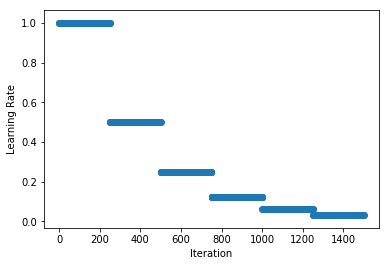

In [3]:
schedule = mx.lr_scheduler.FactorScheduler(step=250, factor=0.5)
schedule.base_lr = 1
plot_schedule(schedule)

Note: the `base_lr` is used to determine the initial learning rate. It takes a default value of 0.01 since we inherit from `mx.lr_scheduler.LRScheduler`, but it can be set as a property of the schedule. We will see later in this tutorial that `base_lr` is set automatically when providing the `lr_schedule` to `Optimizer`. Also be aware that the schedules in `mx.lr_scheduler` have state (i.e. counters, etc) so calling the schedule out of order may give unexpected results.

We can define non-uniform intervals with `MultiFactorScheduler` and in the example below we halve the learning rate _after_ the 250th, 750th (i.e. a step length of 500 iterations) and 900th (a step length of 150 iterations). As before, the learning rate of the 250th iteration will be 1 and the 251th iteration will be 0.5.

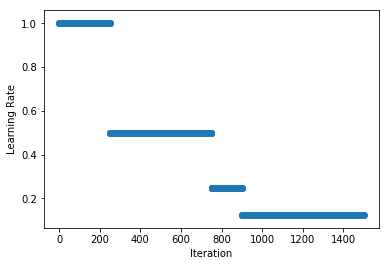

In [4]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=[250, 750, 900], factor=0.5)
schedule.base_lr = 1
plot_schedule(schedule)

### Polynomial Schedule

Stepwise schedules and the discontinuities they introduce may sometimes lead to instability in the optimization, so in some cases smoother schedules are preferred. `PolyScheduler` gives a smooth decay using a polynomial function and reaches a learning rate of 0 after `max_update` iterations. In the example below, we have a quadratic function (`pwr=2`) that falls from 0.998 at iteration 1 to 0 at iteration 1000. After this the learning rate stays at 0, so nothing will be learnt from `max_update` iterations onwards.

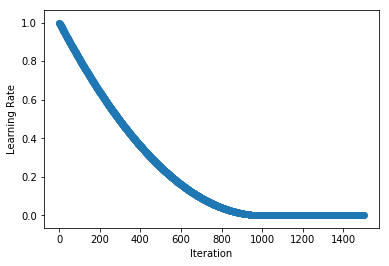

In [5]:
schedule = mx.lr_scheduler.PolyScheduler(max_update=1000, base_lr=1, pwr=2)
plot_schedule(schedule)

Note: unlike `FactorScheduler`, the `base_lr` is set as an argument when instantiating the schedule.

And we don't evaluate at `iteration=0` (to get `base_lr`) since we are working with schedules starting at `iteration=1`.

### Custom Schedules

You can implement your own custom schedule with a function or callable class, that takes an integer denoting the iteration index (starting at 1) and returns a float representing the learning rate to be used for that iteration. We implement the Cosine Annealing Schedule in the example below as a callable class (see `__call__` method).

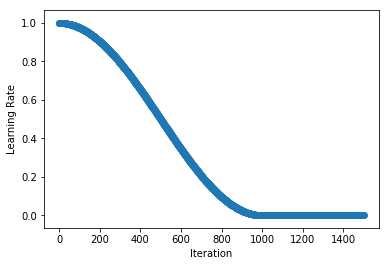

In [6]:
class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        
    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr


schedule = CosineAnnealingSchedule(min_lr=0, max_lr=1, cycle_length=1000)
plot_schedule(schedule)

## Using Schedules

While training a simple handwritten digit classifier on the MNIST dataset, we take a look at how to use a learning rate schedule during training. Our demonstration model is a basic convolutional neural network. We start by preparing our `DataLoader` and defining the network. 

As discussed above, the schedule should return a learning rate given an (1-based) iteration index.

In [7]:
# Use GPU if one exists, else use CPU
ctx = mx.gpu() if mx.test_utils.list_gpus() else mx.cpu()

# MNIST images are 28x28. Total pixels in input layer is 28x28 = 784
num_inputs = 784
# Clasify the images into one of the 10 digits
num_outputs = 10
# 64 images in a batch
batch_size = 64

# Load the training data
train_dataset = mx.gluon.data.vision.MNIST(train=True).transform_first(transforms.ToTensor())
train_dataloader = mx.gluon.data.DataLoader(train_dataset, batch_size, shuffle=True)

# Build a simple convolutional network
def build_cnn():
    net = nn.HybridSequential()
    with net.name_scope():
        # First convolution
        net.add(nn.Conv2D(channels=10, kernel_size=5, activation='relu'))
        net.add(nn.MaxPool2D(pool_size=2, strides=2))
        # Second convolution
        net.add(nn.Conv2D(channels=20, kernel_size=5, activation='relu'))
        net.add(nn.MaxPool2D(pool_size=2, strides=2))
        # Flatten the output before the fully connected layers
        net.add(nn.Flatten())
        # First fully connected layers with 512 neurons
        net.add(nn.Dense(512, activation="relu"))
        # Second fully connected layer with as many neurons as the number of classes
        net.add(nn.Dense(num_outputs))
        return net
    
net = build_cnn()

We then initialize our network (technically deferred until we pass the first batch) and define the loss.

In [8]:
# Initialize the parameters with Xavier initializer
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
# Use cross entropy loss
softmax_cross_entropy = mx.gluon.loss.SoftmaxCrossEntropyLoss()

We're now ready to create our schedule, and in this example we opt for a stepwise decay schedule using `MultiFactorScheduler`. Since we're only training a demonstration model for a limited number of epochs (10 in total) we will exaggerate the schedule and drop the learning rate by 90% after the 4th, 7th and 9th epochs. We call these steps, and the drop occurs _after_ the step index. Schedules are defined for iterations (i.e. training batches), so we must represent our steps in iterations too.

In [9]:
steps_epochs = [4, 7, 9]
# assuming we keep partial batches, see `last_batch` parameter of DataLoader
iterations_per_epoch = math.ceil(len(train_dataset) / batch_size)
# iterations just before starts of epochs (iterations are 1-indexed)
steps_iterations = [s*iterations_per_epoch for s in steps_epochs]
print("Learning rate drops after iterations: {}".format(steps_iterations))

Learning rate drops after iterations: [3752, 6566, 8442]


In [10]:
schedule = mx.lr_scheduler.MultiFactorScheduler(step=steps_iterations, factor=0.1)

**We create our `Optimizer` and pass the schedule via the `lr_scheduler` parameter.** In this example we're using Stochastic Gradient Descent.

In [11]:
sgd_optimizer = mx.optimizer.SGD(learning_rate=0.03, lr_scheduler=schedule)

And we use this optimizer (with schedule) in our `Trainer` and train for 10 epochs. Alternatively, we could have set the `optimizer` to the string `sgd`, and pass a dictionary of the optimizer parameters directly to the trainer using `optimizer_params`.

In [12]:
trainer = mx.gluon.Trainer(params=net.collect_params(), optimizer=sgd_optimizer)

In [13]:
num_epochs = 10
# epoch and batch counts starting at 1
for epoch in range(1, num_epochs+1):
    # Iterate through the images and labels in the training data
    for batch_num, (data, label) in enumerate(train_dataloader, start=1):
        # get the images and labels
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # Ask autograd to record the forward pass
        with mx.autograd.record():
            # Run the forward pass
            output = net(data)
            # Compute the loss
            loss = softmax_cross_entropy(output, label)
        # Compute gradients
        loss.backward()
        # Update parameters
        trainer.step(data.shape[0])

        # Show loss and learning rate after first iteration of epoch
        if batch_num == 1:
            curr_loss = mx.nd.mean(loss).asscalar()
            curr_lr = trainer.learning_rate
            print("Epoch: %d; Batch %d; Loss %f; LR %f" % (epoch, batch_num, curr_loss, curr_lr))

Epoch: 1; Batch 1; Loss 2.304071; LR 0.030000
Epoch: 2; Batch 1; Loss 0.059640; LR 0.030000
Epoch: 3; Batch 1; Loss 0.072601; LR 0.030000
Epoch: 4; Batch 1; Loss 0.042228; LR 0.030000
Epoch: 5; Batch 1; Loss 0.025745; LR 0.003000
Epoch: 6; Batch 1; Loss 0.027391; LR 0.003000
Epoch: 7; Batch 1; Loss 0.048237; LR 0.003000
Epoch: 8; Batch 1; Loss 0.024213; LR 0.000300
Epoch: 9; Batch 1; Loss 0.008892; LR 0.000300
Epoch: 10; Batch 1; Loss 0.006875; LR 0.000030


We see that the learning rate starts at 0.03, and falls to 0.00003 by the end of training as per the schedule we defined.

### Manually setting the learning rate: Gluon API only

When using the method above you don't need to manually keep track of iteration count and set the learning rate, so this is the recommended approach for most cases. Sometimes you might want more fine-grained control over setting the learning rate though, so Gluon's `Trainer` provides the `set_learning_rate` method for this.

We replicate the example above, but now keep track of the `iteration_idx`, call the schedule and set the learning rate appropriately using `set_learning_rate`. We also use `schedule.base_lr` to set the initial learning rate for the schedule since we are calling the schedule directly and not using it as part of the `Optimizer`.

In [14]:
net = build_cnn()
net.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

schedule = mx.lr_scheduler.MultiFactorScheduler(step=steps_iterations, factor=0.1)
schedule.base_lr = 0.03
sgd_optimizer = mx.optimizer.SGD()
trainer = mx.gluon.Trainer(params=net.collect_params(), optimizer=sgd_optimizer)

iteration_idx = 1
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    # Iterate through the images and labels in the training data
    for batch_num, (data, label) in enumerate(train_dataloader, start=1):
        # get the images and labels
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        # Ask autograd to record the forward pass
        with mx.autograd.record():
            # Run the forward pass
            output = net(data)
            # Compute the loss
            loss = softmax_cross_entropy(output, label)
        # Compute gradients
        loss.backward()
        # Update the learning rate
        lr = schedule(iteration_idx)
        trainer.set_learning_rate(lr)
        # Update parameters
        trainer.step(data.shape[0])
        # Show loss and learning rate after first iteration of epoch
        if batch_num == 1:
            curr_loss = mx.nd.mean(loss).asscalar()
            curr_lr = trainer.learning_rate
            print("Epoch: %d; Batch %d; Loss %f; LR %f" % (epoch, batch_num, curr_loss, curr_lr))
        iteration_idx += 1

Epoch: 1; Batch 1; Loss 2.334119; LR 0.030000
Epoch: 2; Batch 1; Loss 0.178930; LR 0.030000
Epoch: 3; Batch 1; Loss 0.142640; LR 0.030000
Epoch: 4; Batch 1; Loss 0.041116; LR 0.030000
Epoch: 5; Batch 1; Loss 0.051049; LR 0.003000
Epoch: 6; Batch 1; Loss 0.027170; LR 0.003000
Epoch: 7; Batch 1; Loss 0.083776; LR 0.003000
Epoch: 8; Batch 1; Loss 0.082553; LR 0.000300
Epoch: 9; Batch 1; Loss 0.027984; LR 0.000300
Epoch: 10; Batch 1; Loss 0.030896; LR 0.000030


Once again, we see the learning rate start at 0.03, and fall to 0.00003 by the end of training as per the schedule we defined.

## Advanced Schedules

We have a related tutorial on Advanced Learning Rate Schedules that shows reference implementations of schedules that give state-of-the-art results. We look at cyclical schedules applied to a variety of cycle shapes, and many other techniques such as warm-up and cool-down.